In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.datasets import cifar100
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
print('tensorflow', tf.__version__)

tensorflow 2.10.1


In [ ]:
# checkpoint_filepath = './check.h5'
# callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True
# )

# reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_accuracy',
#     mode='max',
#     factor=0.8,
#     patience=3,
#     cooldown=0,
#     min_lr=0.000001,
#     verbose=1
# )
# callback_Earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3)

In [2]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape = (128, 128, 3))
base_model.trainable = False

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


In [3]:
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.models import Model

input_shape = (32, 32, 3)

model_input = tf.keras.layers.Input(shape=input_shape)
upsampled_input = UpSampling2D(size=(4, 4), interpolation='bicubic')(model_input)
x = base_model(upsampled_input)
x = Flatten()(x)
predictions = tf.keras.layers.Dense(100, activation='softmax', name='softmax')(x)

model = Model(model_input, predictions)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [4]:
print(base_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

資料集前處理

In [5]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)
y_test = to_categorical(y_test, num_classes = 100)
x_train = x_train * 1.0/255
x_val = x_val * 1.0/255
x_test = x_test *1.0/255
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip = True
)
train_datagen.fit(x_train)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


In [8]:
history=model.fit(
    train_datagen.flow(x_train, y_train, batch_size=128),
    validation_data = (x_val, y_val),
    epochs = 50,
    verbose = 1,
    #callbacks = [callback_checkpoint, reduce_learning_rate, callback_Earlystop]
)

Epoch 1/50
313/313 [==============================] - 39s 123ms/step - loss: 4.4304 - accuracy: 0.1222 - val_loss: 15.3535 - val_accuracy: 0.0109
Epoch 2/50
313/313 [==============================] - 38s 120ms/step - loss: 3.0701 - accuracy: 0.2942 - val_loss: 7.9837 - val_accuracy: 0.0157
Epoch 3/50
313/313 [==============================] - 38s 122ms/step - loss: 2.5581 - accuracy: 0.3796 - val_loss: 3.0666 - val_accuracy: 0.2820
Epoch 4/50
313/313 [==============================] - 38s 122ms/step - loss: 2.2757 - accuracy: 0.4351 - val_loss: 2.2903 - val_accuracy: 0.4321
Epoch 5/50
313/313 [==============================] - 38s 121ms/step - loss: 2.0820 - accuracy: 0.4731 - val_loss: 2.1285 - val_accuracy: 0.4708
Epoch 6/50
313/313 [==============================] - 38s 121ms/step - loss: 1.9491 - accuracy: 0.4997 - val_loss: 2.0435 - val_accuracy: 0.4926
Epoch 7/50
313/313 [==============================] - 38s 121ms/step - loss: 1.8140 - accuracy: 0.5239 - val_loss: 1.9793 - val_a

模型評估

In [9]:
import matplotlib.pyplot as plt
def plot_acc_loss(result):
  # function to plot the accuracy and loss graphs
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()
  loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
  print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

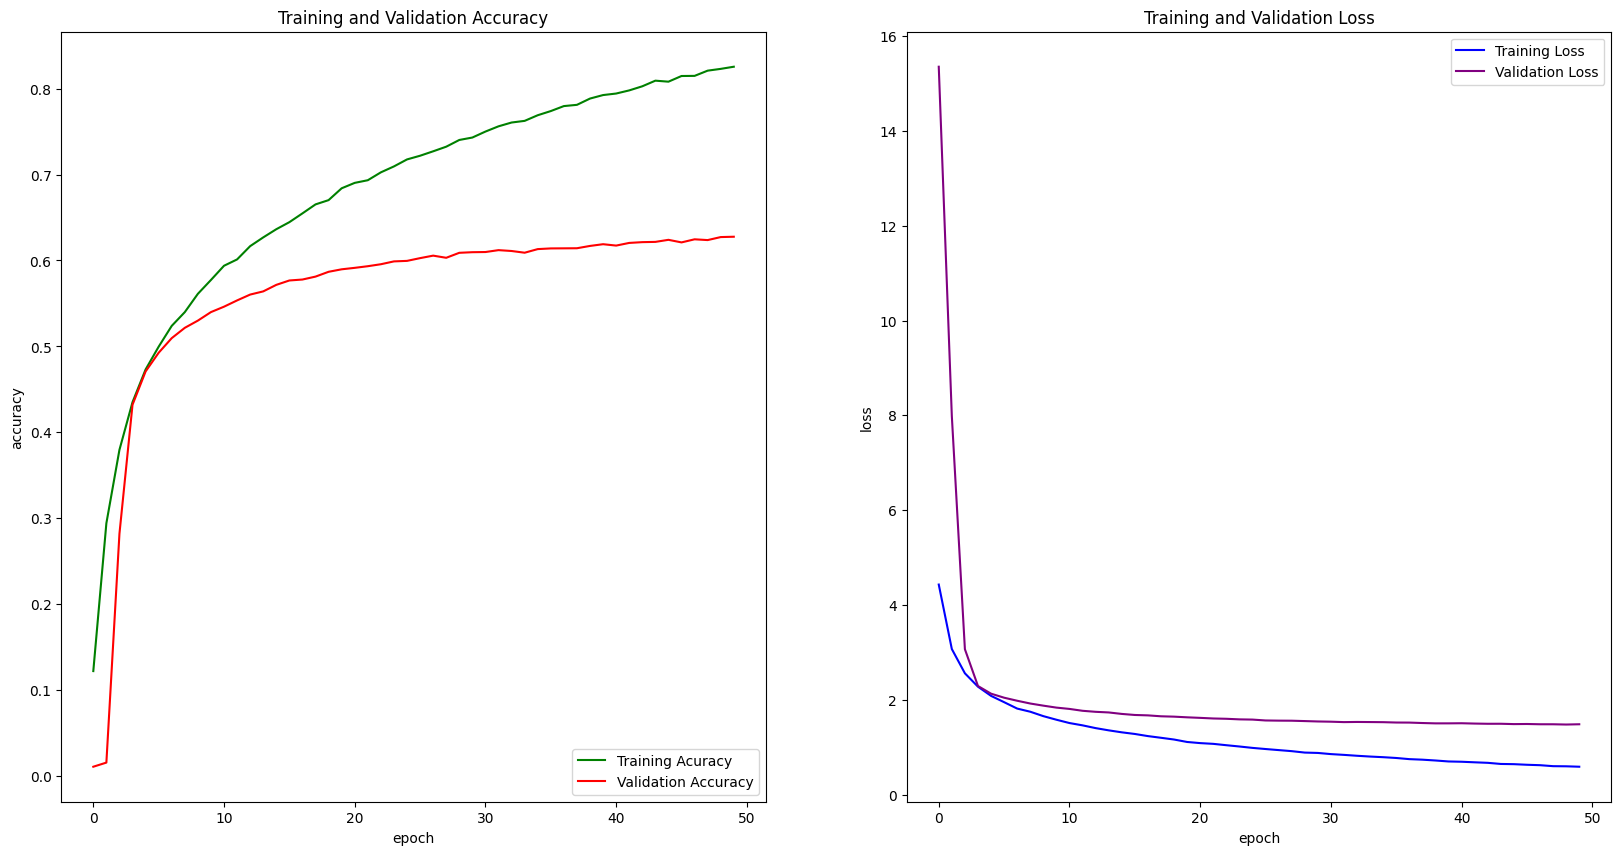

Testing Accuracy = 63.82 %    loss = 1.460194


In [10]:
plot_acc_loss(history)

載入權重

In [ ]:
#model.load_weights(checkpoint_filepath)

再次訓練

In [ ]:
# history2=model.fit(
#     train_datagen.flow(x_train, y_train, batch_size=128),
#     validation_data = (x_val, y_val),
#     epochs = 30,
#     verbose = 1,
#     callbacks = [callback_checkpoint, reduce_learning_rate, callback_Earlystop]
# )

模型評估

In [ ]:
# loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
# print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))